# Astro6410 Final Project
Generative Classification with SNRs and Interstellar Emission

In [1]:
### Attempting to employ the Generative Classification methods of the data mining textbook section 9.3
### for a project in Anil's 6410 class.

## Setting Up

In [2]:
### Importing the various packages I use

### plotting and math
import numpy as np
from scipy import interpolate
import scipy as sp
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm

### for coordinate work
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord

### for file reading & writing
from astropy.io import fits
from astropy.io.votable import parse
import csv
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

### Retrieving the Data

In [3]:
### Importing the .fits file with all stars around SNRs
select_stars = 'Stars_in_SNRs_V7_SNRDistOnly.fits'
SNR_stars_hdus = fits.open(select_stars)
SNR_star_list = SNR_stars_hdus[1].data
### Header contains info on emission strength, pos'n and stellar params
SNR_star_headers = SNR_stars_hdus[1].header 
SNR_stars_hdus.close()

In [4]:
### Importing Green's Catalogue of Galactic SNRs (2019 ed.)
SNR_catalog_dir = 'GreenSNR.vot'
votable = parse(SNR_catalog_dir)
GreensCat = votable.get_first_table().to_table()

### Create a list of all SNRs in Green's cat. present in the .fits file
Green_IDs = []
for g in range(len(SNR_star_list)):
    if SNR_star_list['GREEN_ID'][g] not in Green_IDs:
        Green_IDs.append(SNR_star_list['GREEN_ID'][g])

### Importing the SNR distance estimates I pulled from Green's website
green_dist = 'SNR_distances.csv'
SNR_dist = []
with open(green_dist) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[1] == '':
            SNR_dist.append(np.NaN)
        else:
            SNR_dist.append(float(row[1]))

### Notes on what parameters are available in this file

These stars are all w/i 2x the remnant radius for one of the Galactic SNRs
presented in Green's catalogue (2019 ed.). Each star has
been assigned to it's 'nearby' remnant via index in G19.

Params taken from APOGEE allStar file include:
 - RA/DEC
 - TEFF, LOGG, M_H
 - RV (necessary to shift spectrum to observed frame)

Angular Separation (SEPARATION) between the star and the center of the nearby SNR.

Distances (DIST) taken from aspcap (?) estimates

Emission strength (EMSTR) calculated as defined in my thesis. This
process involves dividing the observed spectrum by the
ASPCAP best-fit, and a median stellar spectrum made from
stars with similar parameters. The equivalent width in the
region of the 16065AA feature is then divided by the E.W.
of a nearby feature-less region (to normalize the noise).
I call this total measurement W', or the emission strength.
Stars with visible emission features (by eye) may have 
W' > 1.01.

### Note on NaNs
I used to have some data with EMSTR values as NaNs, which is a product of masking some very high-error pixels. As of April 14th, 2020, I have removed these stars from the datafile, which reduces the sample of ~7,000 by about ~500 stars. 

In [5]:
### Picking some data features to use for classification, and preparing them
### in the appropriate format

### Right now only using two features - separation from remnant center,
### and emission strength. Code is modular to change what features are needed.

### You can choose between angular and physical separation.
features = ['PHYS_SEP', 'EMSTR']

data = np.zeros(shape=(len(SNR_star_list),len(features)))
for s in range(len(SNR_star_list)):
    for f in range(len(features)):
        data[s][f] = SNR_star_list[s][features[f]]

In [6]:
### Here is the info of a few stars selected by eye to have the emission feature we are looking at.
target_IDs = ['2M05103998+4950187', '2M05105348+4950325', '2M05121617+4853359']

### Want to find the corresponding indices in the master star array,
### and set some value to label them as detections.
detections = np.zeros(shape=len(SNR_star_list))
for this_target in range(len(target_IDs)):
    detections[np.where(SNR_star_list['APOGEE_ID'] == target_IDs[this_target])] = 1
    
# ### We can test to see if this worked correctly
# SNR_star_list['APOGEE_ID'][detections == 1]

In [7]:
### Now that we have our data array X and our labels Y, we need to
### separate them into a training set and a test set.
### Our training set *has* to include our three detections, and also 
### some non-detections. 

### By eye, we're pretty sure that for the SNR G159.6+07.3, only those
### three stars (all from the same SNR, btw) have the feature. So let's
### use that entire remnant as our training set.
### First find the indices of all stars for that SNR.
training_remnant = 'G159.6+07.3'
training_star_indices = np.where(SNR_star_list['REMNANT'] == training_remnant)[0]

### Renaming our master arrays to fit with the book examples
X, y = data, detections

### Now define some training and testing arrays that we will fill
X_train = np.zeros(shape=(len(training_star_indices),len(features)))
X_test = np.zeros(shape=(len(SNR_star_list) - len(training_star_indices),len(features)))
y_train = np.zeros(shape=len(training_star_indices))
y_test = np.zeros(shape=len(SNR_star_list) - len(training_star_indices))

### Now split the data into training and test arrays based on if they belong
### to remnant G159.6+07.3 or not.

### We need a way to keep track of indices between the master list and the test/train sets.
### Let's make two arrays (test & train) to store the master indices
index_train = np.zeros(shape=len(X_train), dtype=int)
index_test = np.zeros(shape=len(X_test), dtype=int)

### Some counters to help index our new arrays
train_count, test_count = 0, 0
for this_star in range(len(SNR_star_list)):
    ### If a star belongs to G159.6+07.3, put it in the training set.
    if (this_star in training_star_indices):
        X_train[train_count] = X[training_star_indices[np.where(this_star == training_star_indices)][0]]
        y_train[train_count] = y[training_star_indices[np.where(this_star == training_star_indices)][0]]
        index_train[train_count] = training_star_indices[np.where(this_star == training_star_indices)][0]
        train_count = train_count + 1
    ### Otherwise, put it in the testing set.
    else:
        X_test[test_count] = X[this_star]
        y_test[test_count] = y[this_star]
        index_test[test_count] = this_star
        test_count = test_count + 1

## Modified Code from Text Book
To test out some methods from Section 9.3, I'm playing with codes used to make figures from the text.

### Gaussian Naive Bayes (Physical Sep.)

In [9]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.naive_bayes import GaussianNB
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

In [10]:
### Trying to replicate the book code w/ my data
### Already split the data into training and testing.

### The number of total points
N_tot = len(y)
### The number of non-variable stars in the entire dataset
N_st = np.sum(y == 0)
### The number of variable stars in the entire dataset
N_rr = N_tot - N_st
### The number of stars in the training set
N_train = len(y_train)
### The number of stars in the test set
N_test = len(y_test)
### The number of v. stars in the entire dataset, but + 5000
### IDK why this step is here, but assume it's for plotting
N_plot = 5000 + N_rr

In [11]:
### Performing Naive Bayes
classifiers = []
predictions = []
Ncolors = np.arange(1, X.shape[1] + 1)

for nc in Ncolors:
    ### Generate our classifier function and fit to one dimension of training data
    clf = GaussianNB()
    clf.fit(X_train[:, :nc], y_train)
    ### Apply the classifier function to the same dimension of test data to predict labels
    y_pred = clf.predict(X_test[:, :nc])

    classifiers.append(clf)
    ### This is where we store the predicted labels. Since there are labels
    ### for each dimension of data, you can pick which one to look at.
    ### I have found them to be almost always identical, so I default to
    ### using the last set of labels (now stored as ypred).
    predictions.append(y_pred)

In [12]:
#------------------------------------------------------------
# Compute the decision boundary
clf = classifiers[1]

### Limits for when using Physical Separation
xlim = (0.96, 1.06)
ylim = (0, 0.35)

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 81),
                     np.linspace(ylim[0], ylim[1], 71))

Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])
Z = Z[:, 1].reshape(xx.shape)

Text(0, 0.5, 'Sep. from Remnant Center (kpc)')

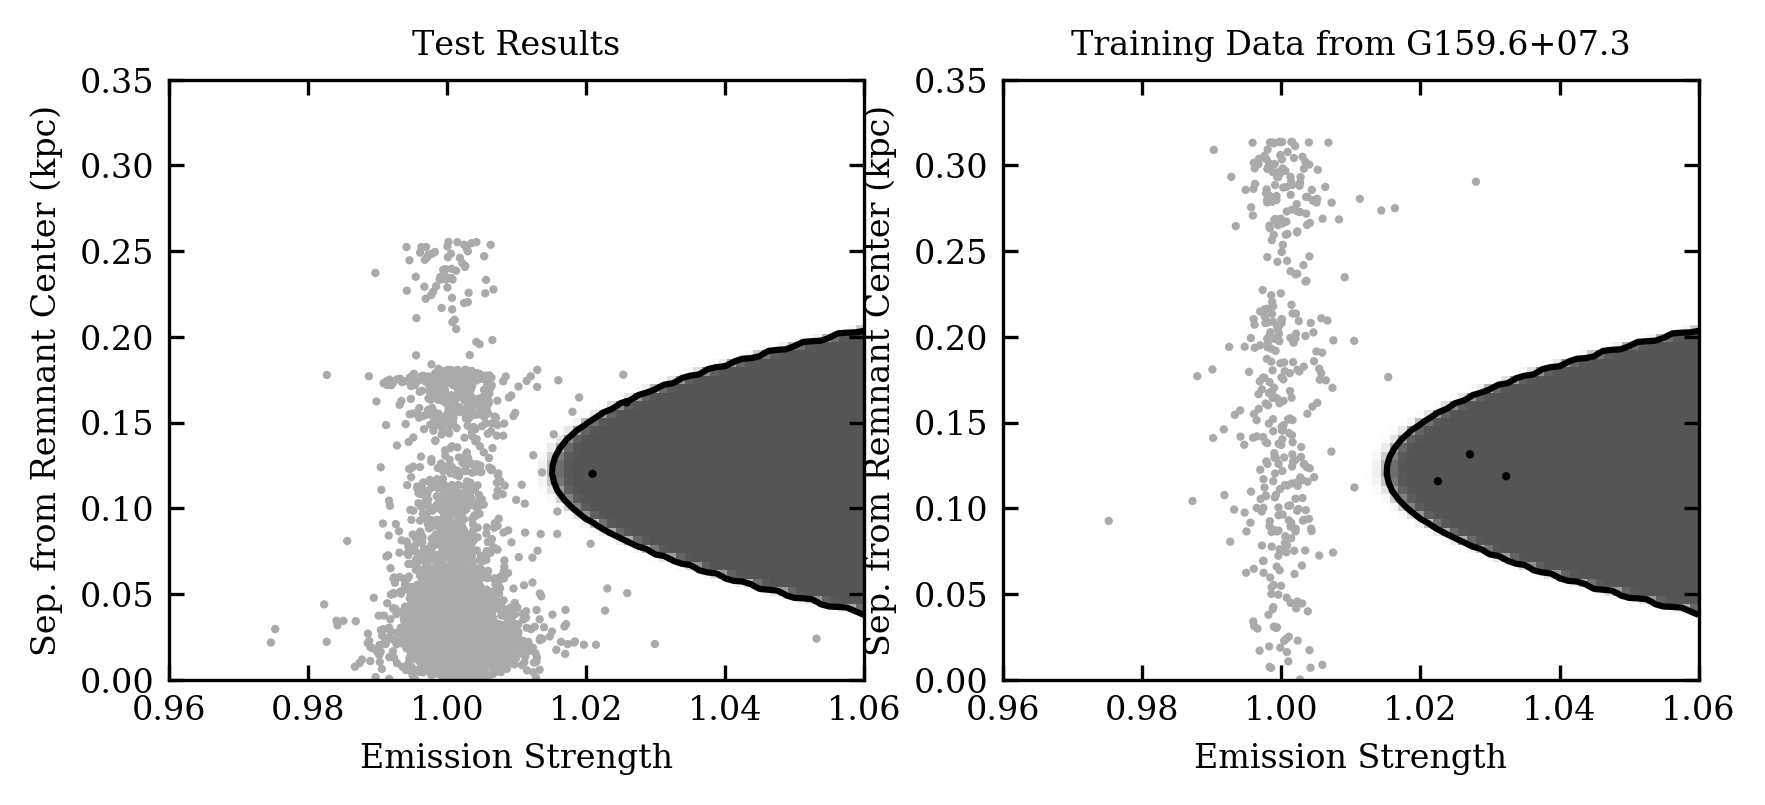

In [13]:
# plot the results
fig = plt.figure(figsize=(6, 2.5), dpi=300)
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(121)
im = ax.scatter(X_test[:, 1], X_test[:, 0], c=y_pred,
                s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Test Results')
ax.set_xlabel('Emission Strength')
ax.set_ylabel('Sep. from Remnant Center (kpc)')

# Plot training data for comparison
ax = plt.subplot(122)
im = ax.scatter(X_train[:,1], X_train[:,0], c=y_train,
               s=4, lw=0, cmap=plt.cm.binary, zorder=2)
im.set_clim(-0.5, 1)

im = ax.imshow(Z, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.5)
ax.contour(xx, yy, Z, [0.5], colors='k')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_title('Training Data from G159.6+07.3')
ax.set_xlabel('Emission Strength')
ax.set_ylabel('Sep. from Remnant Center (kpc)')

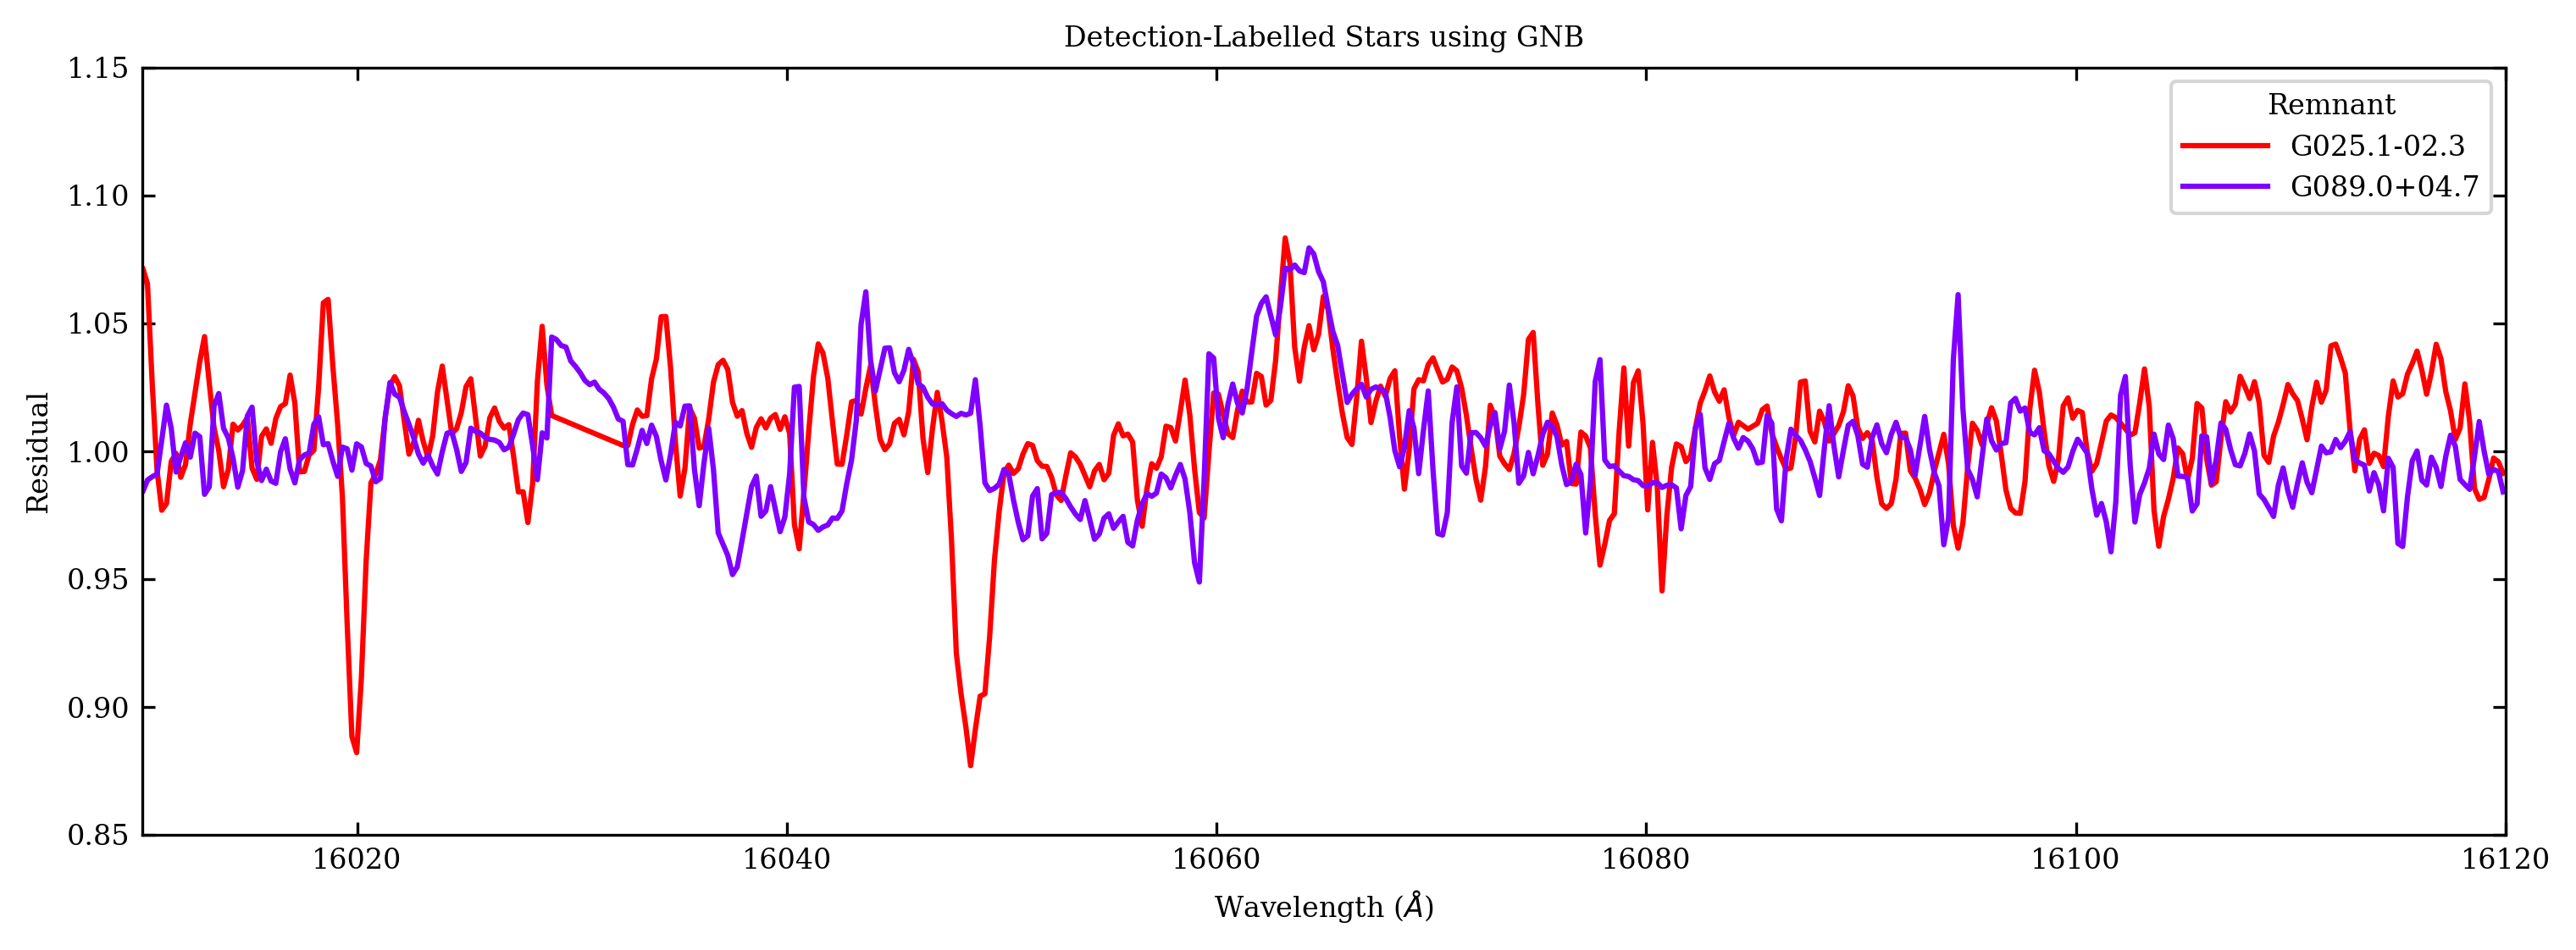

<Figure size 432x288 with 0 Axes>

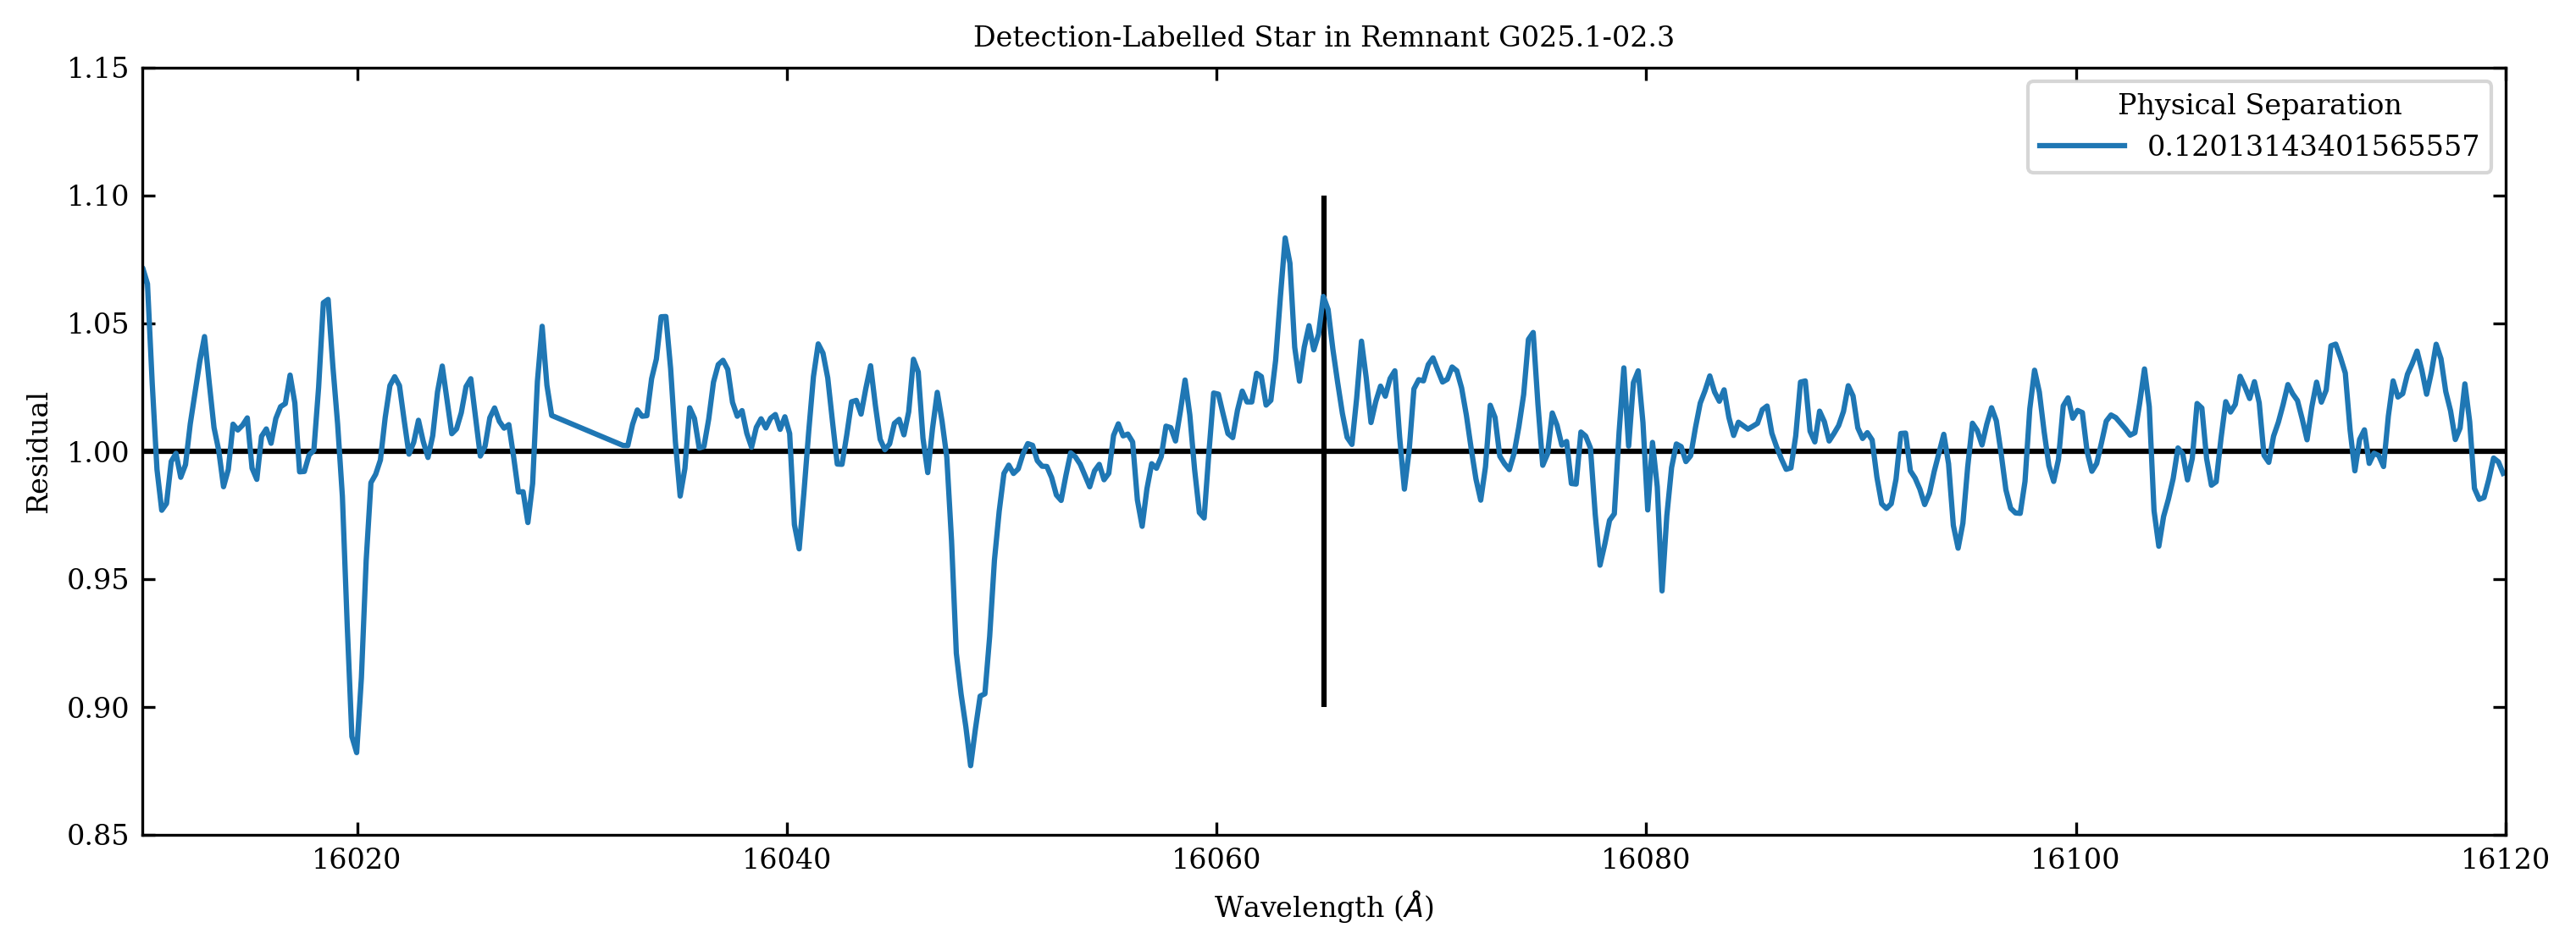

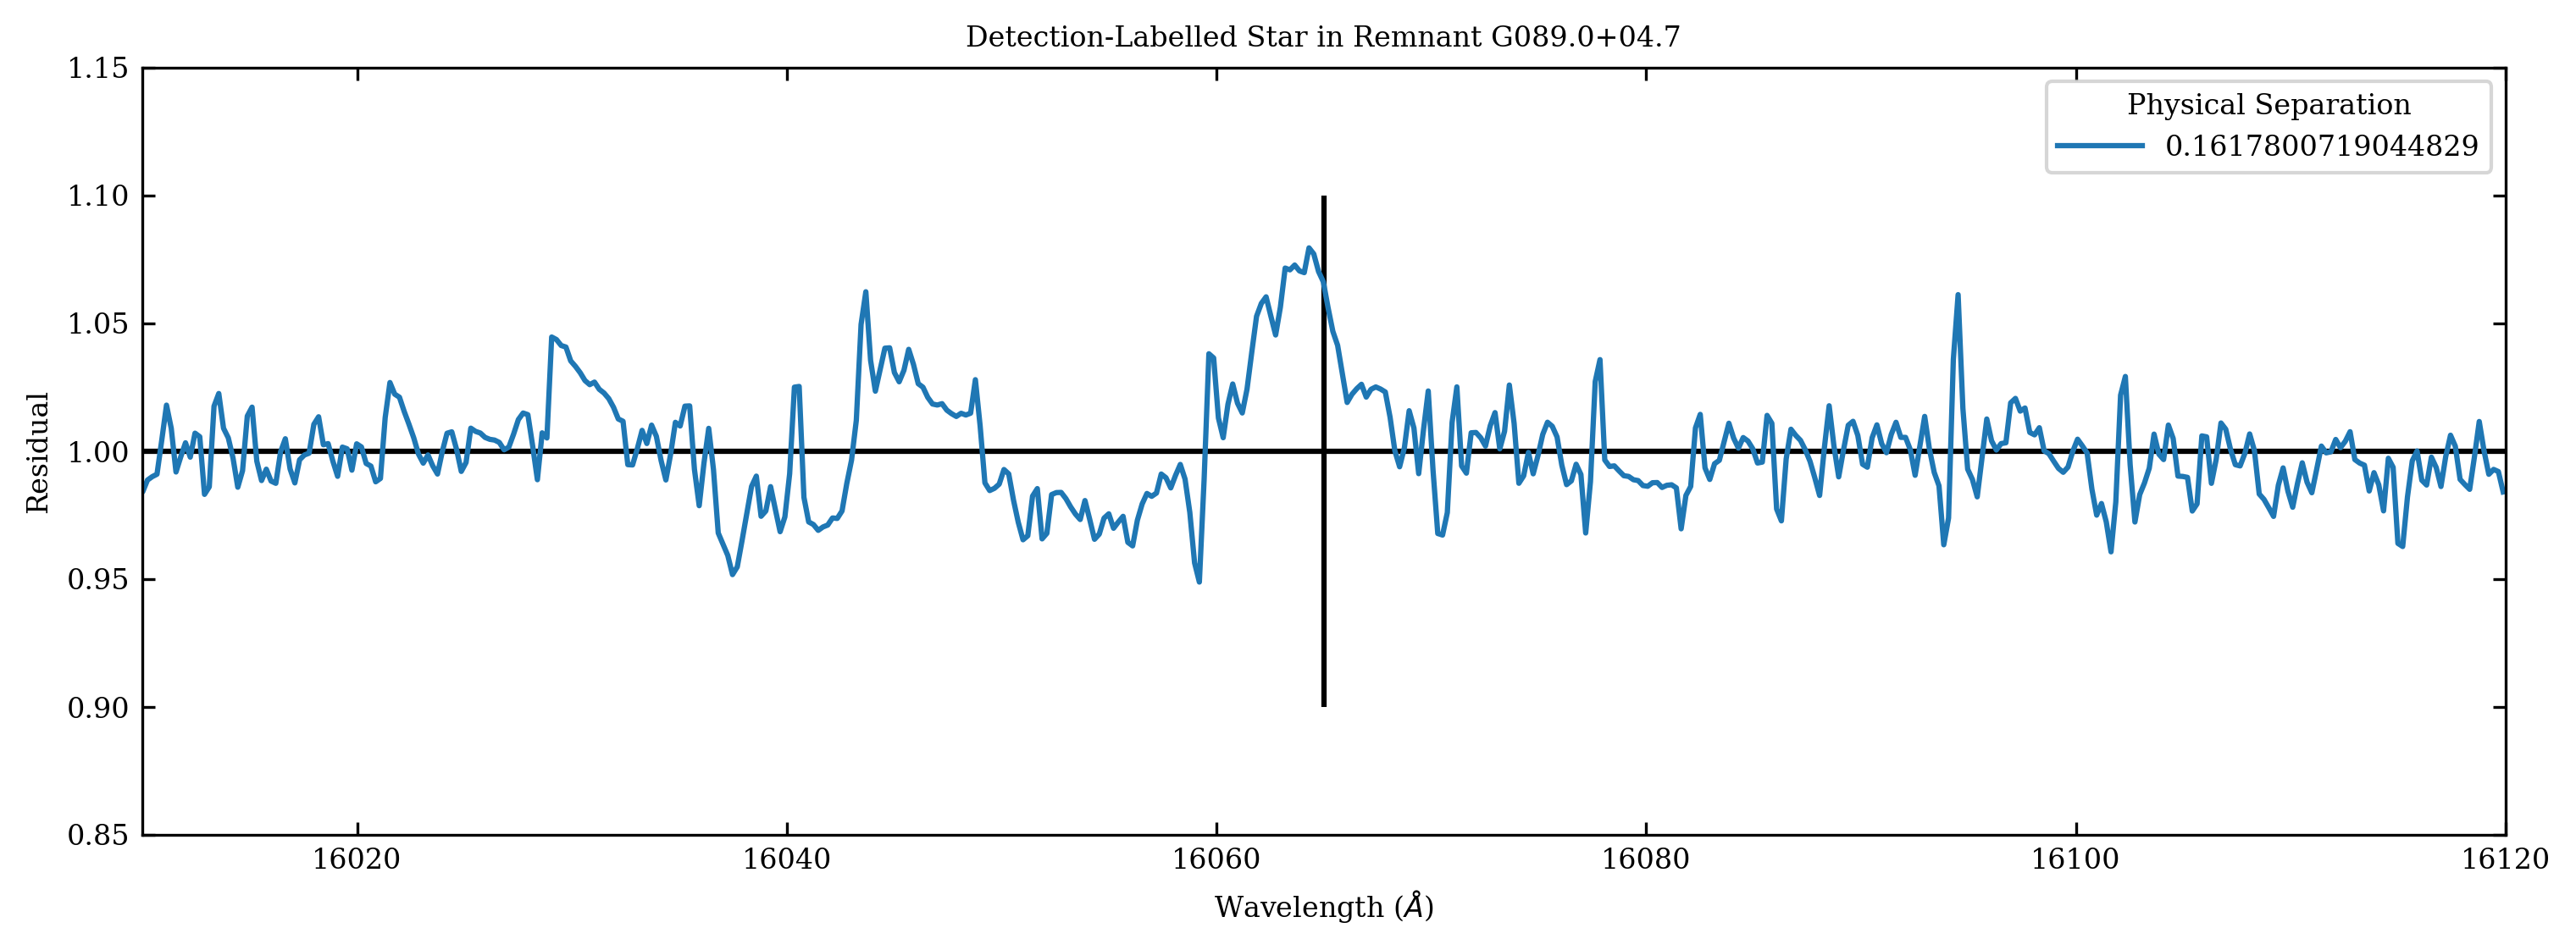

<Figure size 432x288 with 0 Axes>

In [14]:
### Looking at the (processed residual) spectra of those stars
### labelled as 'detections'

### Setting up some plots
count = 0
colors = cm.rainbow(np.linspace(1, 0, len(np.where(y_pred == 1)[0])))
plt.figure(figsize=(12,4), dpi=300)

for i in range(len(y_pred)):
    if y_pred[i] == 1:
        detection_index = index_test[i]
        ### Pulling the wavelength and residual arrays
        this_wave = SNR_star_list['WAVE'][detection_index]
        this_resid = SNR_star_list['RESID'][detection_index]
        ### Plotting the spectrum
        plt.plot(this_wave, this_resid, color=colors[count],label=SNR_star_list['REMNANT'][detection_index])
        plt.xlim(16010, 16120)
        plt.ylim(0.85, 1.15)
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Residual')
        plt.title('Detection-Labelled Stars using GNB')
        count = count + 1
plt.legend(title='Remnant')
plt.show()
plt.clf()

### Let's group the stars by their remnants
detection_remnants = []
for i in range(len(y_pred)):
    if y_pred[i] == 1:
        detection_remnants.append(SNR_star_list['REMNANT'][index_test[i]])
        
for this_remnant in np.unique(detection_remnants):
    plt.figure(figsize=(12,4), dpi=300)
    for i in range(len(y_pred)):
        if y_pred[i] == 1 and SNR_star_list['REMNANT'][index_test[i]] == this_remnant:
            this_wave = SNR_star_list['WAVE'][index_test[i]]
            this_resid = SNR_star_list['RESID'][index_test[i]]
            plt.plot(this_wave, this_resid, label=SNR_star_list['PHYS_SEP'][index_test[i]])
    plt.xlim(16010, 16120)
    plt.ylim(0.85, 1.15)
    plt.hlines(y=1, xmin=16000, xmax=16120, zorder=0)
    plt.vlines(x=16065, ymin=0.9, ymax=1.1, zorder=0)
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Residual')
    plt.title('Detection-Labelled Star in Remnant {}'.format(this_remnant))
    plt.legend(title='Physical Separation')
    plt.show()
plt.clf()